<a href="https://colab.research.google.com/github/abyssinia28/Machine-Learning/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Libraries

In [0]:
import os
from sklearn import preprocessing
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import math
import time
import seaborn as sns
import datetime
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras import regularizers
from keras.layers import Dropout, BatchNormalization
from sklearn.model_selection import train_test_split

# Preprocessing data
Time lagging of predictors

In [0]:
def time_lag(data, lags):
    """
    Transforms the dataset to  a time series of grid information 
    and spits back the time lagged time series
    data - the full name of the csv file
    """
    time_origal = pd.to_datetime('1900-01-01')

    dat = pd.read_csv(data)
    dat.columns = ['time', 'u10', 'v10', 'slp', 'weight', 'surge'] 
    
    #reorganize the matrix
    dat_new = dat.loc[dat['weight'] == dat['weight'].unique()[0]]
    dat_new.drop(['weight'], axis = 1, inplace=True) #, 'surge'
    
    for ii in range(1,10):
        dat_sub = dat.loc[dat['weight'] == dat['weight'].unique()[ii]]
        dat_sub.drop(['weight', 'surge'], axis = 1, inplace=True)
        dat_new = pd.merge(dat_new, dat_sub, on='time')
    
    
    #lag the time series
    lagged = dat_new.copy() #to prevent modifying original matrix
    for jj in range(lags):
        #lagged.drop(jj, axis = 0, inplace = True)
        lagged['time'] = lagged['time'] + 6
        #remove the last row since there is no match for it in dat_new
        lagged.drop(lagged.tail(1).index.item(), axis = 0, inplace = True)
        #remove the topmost row from dat_new to match lagged
        dat_new.drop(dat_new.head(1).index.item(), axis = 0, inplace = True)
        #merge lagged and dat_new
        dat_new = pd.merge(dat_new, lagged, on = 'time', how = 'outer', \
                       suffixes = ('_left', '_right'))
    dat_new = dat_new.T.reset_index(drop=True).T
    ind = dat_new.loc[pd.isna(dat_new[dat_new.shape[1]-1]), :].index
    dat_new.drop(ind,inplace=True)
    
    
    #surge time series
    surge_ts = pd.DataFrame(dat.loc[dat['weight'] == \
                                dat['weight'].unique()[0]][['time', 'surge']])
    #remove nan values
    surge_ts.reset_index(inplace=True) #reset index for subsetting isnans
    surge_ts.drop(['index'], axis = 1, inplace=True)    
    indx = surge_ts.loc[pd.isna(surge_ts["surge"]), :].index
    dat_new.drop(indx,inplace=True)
    surge_ts.drop(indx,inplace=True)
    #filter surge accoring to dat_new
    lagged_time = list(dat_new[0])
    time_dat_new = [float(x) for x in dat_new[0]]
    time_surge_ts = [float(x) for x in surge_ts['time']]
    time_both = []
    for kk in lagged_time:
        if ((kk in time_dat_new) & (kk in time_surge_ts)):
            time_both.append(int(kk))
            
    surge_ts = surge_ts[surge_ts['time'].isin(time_both)]
    
    dt = pd.DataFrame(columns = ['date']);
    for ii in surge_ts.index:
        dt.loc[ii, 'date'] = time_origal + \
            datetime.timedelta(hours = int(surge_ts.loc[ii, 'time']))
            
    surge_ts['date'] = dt
    dat_new = dat_new[dat_new[0].isin([x*1.0 for x in time_both])]
    dat_new.drop(4, axis = 1, inplace = True) #remove the un-lagged surge 
    return dat_new, surge_ts

# Preparing the predictor and predictand data

In [0]:
data = '2011_cux.csv'
x, surge = time_lag(data,5)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: FutureWarning: `item` has been deprecated and will be removed in a future version


In [0]:
print(x)

            0         1         2    ...       184       185            186
0      973038.0  3.016050 -3.749202  ...  8.675808  0.804667  101865.320249
1      973044.0  3.787021 -3.592172  ...  7.581304 -3.240309  101555.975612
2      973050.0  2.587885 -2.344656  ...  5.773650 -5.203183  101682.317459
3      973056.0  2.210660 -2.074216  ...  3.730575 -5.655372  101805.042650
4      973062.0  2.441951 -0.915393  ...  4.273009 -4.646309  101850.130294
...         ...       ...       ...  ...       ...       ...            ...
5834  1008042.0  3.226690  0.178001  ... -1.887881 -4.426757  103288.594909
5835  1008048.0  4.420320 -0.333800  ...  3.336829 -0.833970  103484.135439
5836  1008054.0  4.255111 -1.222183  ...  4.548356 -3.423510  103335.852547
5837  1008060.0  5.181654 -0.467566  ...  3.592902 -3.342087  103295.104890
5838  1008066.0  6.102690  1.496762  ...  5.305560 -2.162909  103245.436149

[5839 rows x 186 columns]


In [0]:
print(surge)

         time     surge                 date
5      973038 -0.173340  2011-01-02 06:00:00
6      973044  0.022045  2011-01-02 12:00:00
7      973050 -0.243710  2011-01-02 18:00:00
8      973056 -0.061471  2011-01-03 00:00:00
9      973062 -0.380670  2011-01-03 06:00:00
...       ...       ...                  ...
5839  1008042  0.098466  2014-12-30 18:00:00
5840  1008048  0.056440  2014-12-31 00:00:00
5841  1008054  0.243050  2014-12-31 06:00:00
5842  1008060  0.119040  2014-12-31 12:00:00
5843  1008066  0.189340  2014-12-31 18:00:00

[5839 rows x 3 columns]


# Splitting training set and testing set

In [0]:
x_train, x_test, y_train, y_test = train_test_split(
x, surge, shuffle=False, test_size=0.25, random_state=42)

# Standardizing the training and testing set

In [0]:
x_norm_train = preprocessing.scale(x_train)
x_norm_test = preprocessing.scale(x_test)

# Training the multilayer perceptron model

In [0]:
def mlp_seq(x_norm_train, x_norm_test, y_train, y_test):
    """
    Builds mlp, trains and tests it
    """
    #simple model
    model = Sequential()
    model.add(Dropout(0.2, input_shape = (x_norm_train.shape[1],)))
    model.add(Dense(94, activation = 'sigmoid',\
                    input_shape = (x_norm_train.shape[1],)))
    model.add(Dense(94, activation='sigmoid'))
    model.add(BatchNormalization())
    # model.add(Dense(180, activation='relu'))
    model.add(Dense(1))
    
    #Training model
    model.compile(loss = 'mean_squared_error', optimizer = 'adagrad', \
                  metrics=['mean_squared_error', 'mean_absolute_error'])
    history = model.fit(x_norm_train, y_train['surge'], epochs = 50, \
              batch_size = 10, verbose = 1, validation_split=0.2)
    
    testPredict = model.predict(x_norm_test)
    
    #prepare data for plotting
    yy = y_test[:]
    yy.reset_index(inplace=True)
    yy.drop(['index'], axis = 1, inplace=True) 
    
    #make model evaluation
    from sklearn.metrics import mean_squared_error, \
        mean_absolute_error, r2_score
    print()
    print("mse = ", mean_squared_error(y_test['surge'], testPredict))
    print("mae = ", mean_absolute_error(y_test['surge'], testPredict))
    print("r2_score = ", r2_score(y_test['surge'], testPredict))

    print()
    
    #plotting 
    sns.set_context('notebook', font_scale= 1.5)
    plt.figure(figsize=(20,6))
    plt.plot(y_test['date'], yy['surge'], color = 'blue')
    plt.plot(y_test['date'],testPredict, color= 'red')
    plt.legend(['Observed Surge', 'Modeled Surge'],fontsize = 14)
    plt.ylabel('Surge Height (m)')

    fig, ax = plt.subplots()
    ax.scatter(y_test['surge'], testPredict, c='black')
    line = mlines.Line2D([0, 1], [0, 1], color='red')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    plt.show()

    #list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.figure(figsize=(15,8))
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.figure(figsize = (15,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    return testPredict




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.





Train on 3503 samples, validate on 876 samples
Epoch 1/50





3503/3503 [==============================] - 2s 459us/step - loss: 0.1851 - mean_squared_error: 0.1851 - mean_absolute_error: 0.2657 - val_loss: 0.3283 - val_mean_squared_error: 0.3283 - val_mean_absolute_error: 0.4284
Epoch 2/50
3503/3503 [==============================] - 1s 192us/step - loss: 0.0685 - mean_squared_error: 0.0685 - mean_absolute_error: 0.2004 - val_loss: 0.0535 - val_mean_squared_error: 0.0535 - val_mean_absolute_error: 0.1709
Epoch 3/50
3503/3503 [==============================] - 1s 191us/step - loss: 0.0586 - mean_squared_error: 0.0586 - mean_absolute_error: 0.1833 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1875
Epoch 4/50
3503/3503 [==============================] - 1s 199us/step - loss: 0.0568 - mean_squared_error: 0.0568 - mean_absolute_error

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


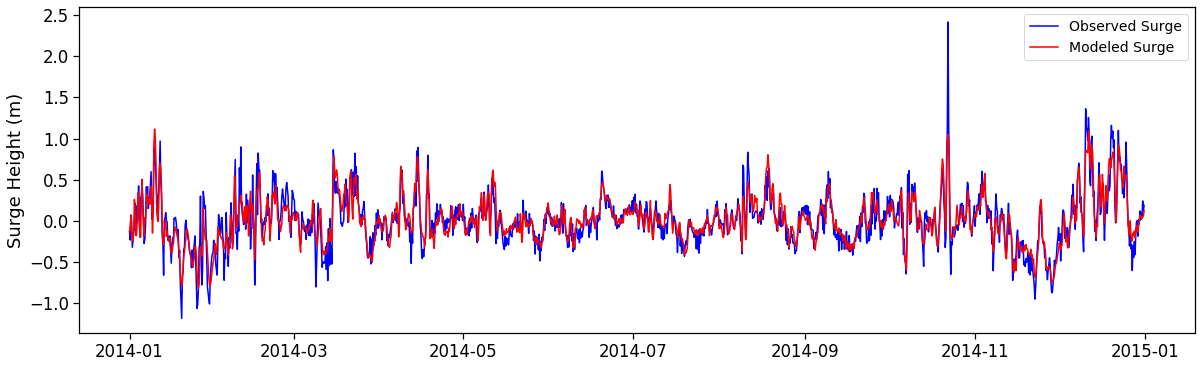

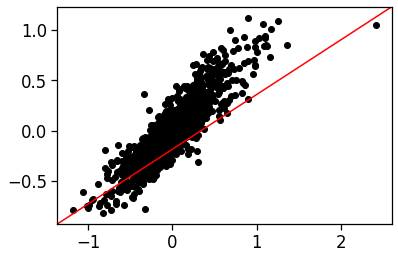

dict_keys(['val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'loss', 'mean_squared_error', 'mean_absolute_error'])


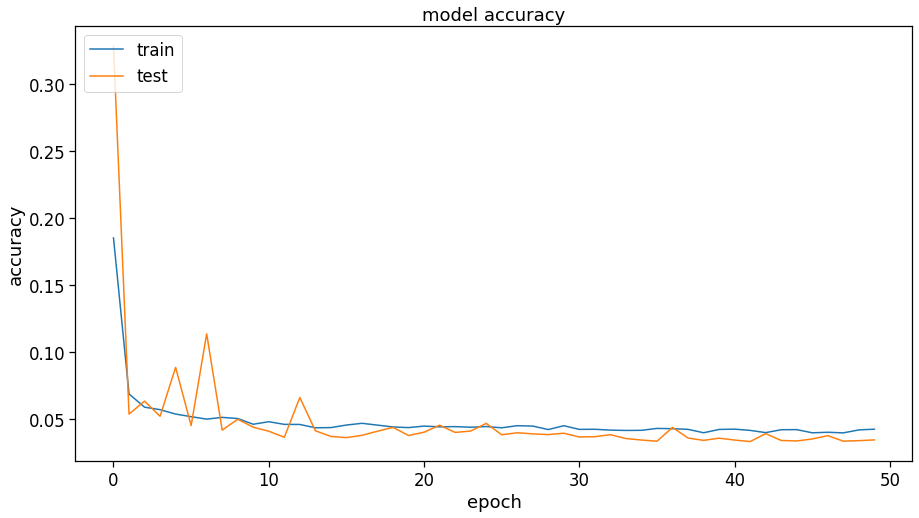

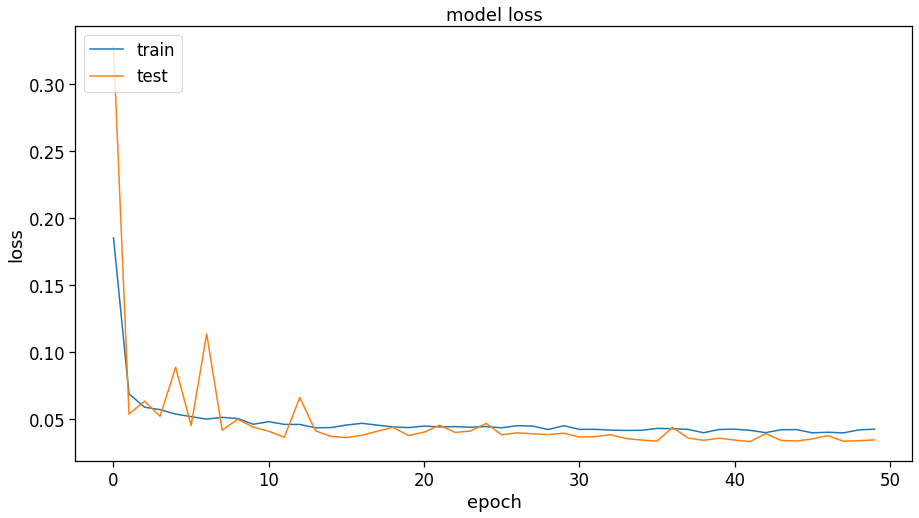

array([[-0.127412  ],
       [-0.05419646],
       [ 0.06401657],
       ...,
       [ 0.05072376],
       [ 0.0591998 ],
       [ 0.12313672]], dtype=float32)

In [0]:
mlp_seq(x_norm_train, x_norm_test, y_train, y_test)